# ☀️ Hybrid Solar Forecast: Seasonal Baseline + XGBoost Residuals
This notebook forecasts solar energy production using a hybrid approach:
- A **seasonal baseline** derived from monthly averages
- An **XGBoost model** trained on residuals (actual − baseline)
- Recursive prediction of residuals for 1 year (8760 hours)

The final forecast is computed as:
```
forecast = seasonal_baseline + predicted_residual
```

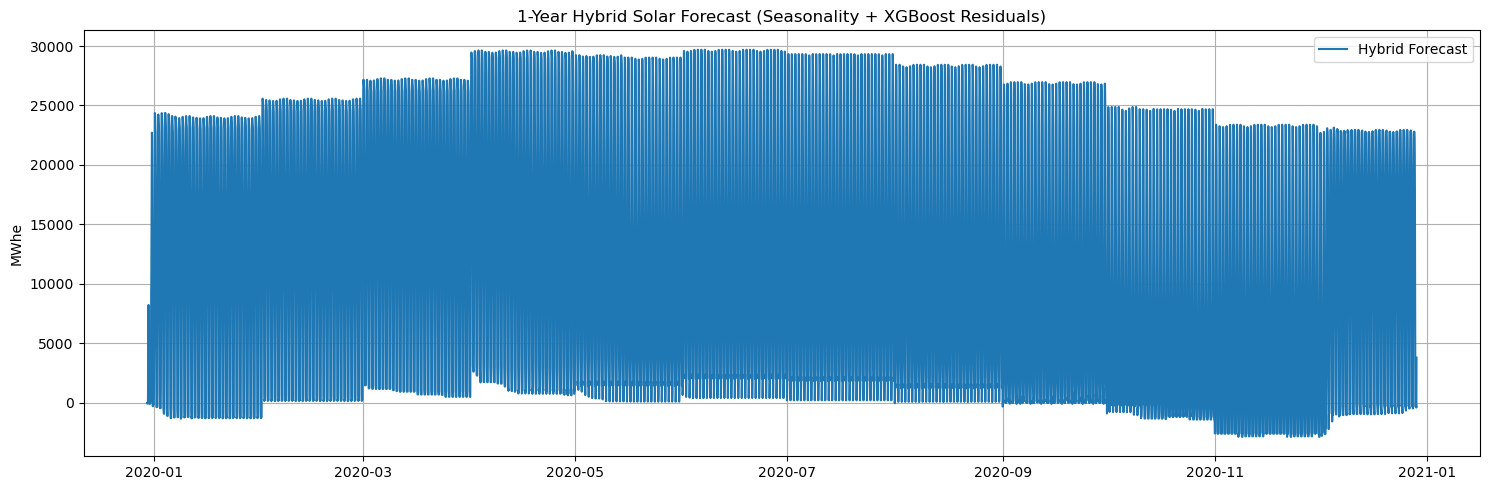

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from xgboost import XGBRegressor

# Load data
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Create monthly seasonal baseline
df['month'] = df.index.month
monthly_avg = df.groupby('month')['DE_solar_generation_actual'].transform('mean')
df['seasonal_baseline'] = monthly_avg

# Compute residuals (what the ML model will learn)
df['residual'] = df['DE_solar_generation_actual'] - df['seasonal_baseline']

# Lag + calendar features for XGBoost
df['residual_lag_1h'] = df['residual'].shift(1)
df['residual_lag_24h'] = df['residual'].shift(24)
df['residual_lag_168h'] = df['residual'].shift(168)
df['residual_roll_24h'] = df['residual'].rolling(24).mean()
df['residual_roll_168h'] = df['residual'].rolling(168).mean()
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# Prepare data
df_feat = df.dropna(subset=['residual'])
features = [
    'residual_lag_1h', 'residual_lag_24h', 'residual_lag_168h',
    'residual_roll_24h', 'residual_roll_168h',
    'hour', 'dayofweek', 'month'
]

X_train = df_feat[features]
y_train = df_feat['residual']

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Start recursive prediction
HORIZON = 8760  # 1 year
history = df_feat.iloc[-900:].copy()
forecasts = []

for step in range(HORIZON):
    next_time = history.index[-1] + timedelta(hours=1)
    month_val = next_time.month
    baseline = df[df['month'] == month_val]['DE_solar_generation_actual'].mean()

    row = {
        'residual_lag_1h': history['residual'].iloc[-1],
        'residual_lag_24h': history['residual'].shift(23).iloc[-1] if len(history) >= 24 else np.nan,
        'residual_lag_168h': history['residual'].shift(167).iloc[-1] if len(history) >= 168 else np.nan,
        'residual_roll_24h': history['residual'].rolling(24).mean().iloc[-1] if len(history) >= 24 else np.nan,
        'residual_roll_168h': history['residual'].rolling(168).mean().iloc[-1] if len(history) >= 168 else np.nan,
        'hour': next_time.hour,
        'dayofweek': next_time.dayofweek,
        'month': month_val
    }

    row_df = pd.DataFrame([row], index=[next_time])
    if row_df.isnull().any(axis=1).iloc[0]:
        break

    predicted_residual = model.predict(row_df[features])[0]
    predicted_value = baseline + predicted_residual

    row_df['DE_solar_generation_actual'] = predicted_value
    row_df['residual'] = predicted_residual
    forecasts.append(row_df[['DE_solar_generation_actual']])
    history = pd.concat([history, row_df[['residual']]])

# Combine forecast
forecast_df = pd.concat(forecasts)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(forecast_df.index, forecast_df['DE_solar_generation_actual'], label='Hybrid Forecast')
plt.title('1-Year Hybrid Solar Forecast (Seasonality + XGBoost Residuals)')
plt.ylabel('MWhe')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

An attempt to properly predict solar energy outcome which could not yield any proper useful results</br>
Finished by Jad Akra on Friday 19th of April 2025